In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import statsmodels.api as sm
from collections import OrderedDict
import sys
import time
import glob
from riboraptor.helpers import path_leaf
import pybedtools
from scipy.stats import poisson
from scipy.signal import savgol_filter

cds_bed = pybedtools.BedTool('/home/cmb-panasas2/skchoudh/github_projects/gencode_regions/data/GRCh38/v25/cds.bed.gz').to_dataframe()

PAPER_PRESET = {"style": "ticks", "font": "Arial", "context": "paper", 
                "rc": {"font.size":20, "axes.titlesize":22,
                       "axes.labelsize":28, 'axes.linewidth': 2,
                       "legend.fontsize":20, "xtick.labelsize": 28,
                       "ytick.labelsize":20, "xtick.major.size": 8.0,
                       "ytick.major.size": 8.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 20
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [3]:
cds_bed.head()

,chrom,start,end,name,score,strand
0,chr1,69090,70008,ENSG00000186092,.,+
1,chr1,182708,182746,ENSG00000279928,.,+
2,chr1,183113,183240,ENSG00000279928,.,+
3,chr1,183921,184158,ENSG00000279928,.,+
4,chr1,184926,184971,ENSG00000279457,.,-


In [5]:
def get_shifted_gene_profile(gene_profile, gene_offset_5p, metagene_offset, atg_location):
    # How many upstream 5'UTr basese were counted?    
    assert gene_offset_5p >= 0    
    # Say -12 is the metagene offset
    assert metagene_offset <= 0
    total_length = len(gene_profile)
    gene_profile = pd.Series(gene_profile, index=np.arange(-gene_offset_5p, len(gene_profile)-gene_offset_5p))
    
    # Shoft -12 to zero by adding the - of metagene_offset
    gene_profile = gene_profile.rename(lambda x: x-metagene_offset)
    
    # For genes whivh are on negatve strand because of 1-offset
    # we end up counting one extra base.
    # So ATG does not start at 0-1-2
    # but at 1-2-3
    # So we need to again do offset
    assert atg_location in [0, 1, 2]
    shifted_gene_profile = gene_profile.rename(lambda x: x-atg_location)
    return shifted_gene_profile

def avg_profiles(samples, gene_name):
    samplewise_profiles = []
    for sample in samples:
        print(sample)
        gene_coverage_tsv = '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP098789/gene_coverages/{}_gene_coverages.tsv.gz'.format(sample)
        gene_coverage = pd.read_csv(gene_coverage_tsv, compression='gzip', sep='\t').set_index('gene_name').loc[gene_name]
        gene_counts = eval(gene_coverage['coverage'])
        #gene_mean = eval(gene_coverage['mean'])
        metagene_offset = -12#metagene_offsets[sample]
        atg_location = 0#codon_map.loc[gene_name]['ATG_first_location']
        #fasta_length = codon_map.loc[gene_name]['fasta_length'] - atg_location
        gene_offset_5p = gene_coverage['offset_5p']
        gene_profile = get_shifted_gene_profile(gene_counts, gene_offset_5p, metagene_offset, atg_location)
        gene_profile = gene_profile#.get(np.arange(0, fasta_length))
        gene_profile_normalized = gene_profile/gene_profile.mean(skipna=True)
        samplewise_profiles.append(gene_profile_normalized)
    samplewise_profiles = np.array(samplewise_profiles)
    return np.nanmean(samplewise_profiles, axis=0)

def sum_profiles(samples, gene_name):
    samplewise_profiles = []
    for sample in samples:
        print(sample)
        gene_coverage_tsv = '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP098789/gene_coverages/{}_gene_coverages.tsv.gz'.format(sample)
        gene_coverage = pd.read_csv(gene_coverage_tsv, compression='gzip', sep='\t').set_index('gene_name').loc[gene_name]
        gene_counts = eval(gene_coverage['coverage'])
        #gene_mean = eval(gene_coverage['mean'])
        metagene_offset = -12#metagene_offsets[sample]
        atg_location = 0#codon_map.loc[gene_name]['ATG_first_location']
        #fasta_length = codon_map.loc[gene_name]['fasta_length'] - atg_location
        gene_offset_5p = gene_coverage['offset_5p']
        gene_profile = get_shifted_gene_profile(gene_counts, gene_offset_5p, metagene_offset, atg_location)
        samplewise_profiles.append(gene_profile)
    samplewise_profiles = np.array(samplewise_profiles)
    return np.nansum(samplewise_profiles, axis=0)

def collpase_gene_coverage_to_codon(gene_profile):
    """Assume the gene 0 is the true zero and exclude 
    trailing positions which are not 0 mod 3
    """
    codon_profile = []
    for i in range(0, len(gene_profile)-3, 3):
        codon_profile.append(np.nansum(gene_profile[np.arange(i, i+3)]))
    return pd.Series(codon_profile, index=np.arange(1, len(codon_profile)+1))
        
def g_transform(data):
    data = np.array(data)
    return np.log(np.log(data+1)+1)

def inverse_g_transform(y):
    y = np.array(y)
    return np.exp(np.exp(y)-1)-1


def baseline_correct(y, n_iterations=100):
    z = g_transform(y)
    z_copy = np.empty(len(z))
    n = len(z)
    for i in range(0, n_iterations):
        for j in range(i, n-i):
            mean_z = 0.5*(z[j-i]+[j+i])
            mean_z = min(mean_z, z[j])
            z_copy[j] = mean_z
        for k in range(i, n-i):
            z[k] = z_copy[k]
    inv_z = inverse_g_transform(z)
    return inv_z



def med_abs_dev(data):
    """Calculate Median absolute deviation
    """
    return 1.4826*max(np.nanmedian(np.abs(data-np.nanmedian(data))), 1e-4)

def calculate_peaks(data, order=3, snr=2.5):
    """ Calculate Peaks
    """
    if isinstance(data, pd.Series):
        index = data.index
    else:
        index = np.arange(0, len(data))
    data = np.array(data)
    data_rel_max_idx = signal.argrelmax(data, axis=0, order=order)[0]
    noise = med_abs_dev(data)
    #peaks_height = np.zeros(len(data))
    peaks_idx = [x for x in data_rel_max_idx if data[x] > snr*noise]
    peaks_x = index[peaks_idx]
    #for x in peaks_idx:
    #    peaks_height[x] = data[x]
    peaks_height = data[peaks_idx]
    return peaks_x, peaks_height

def calculate_snr(data):
    data = np.array(data)
    sigma = med_abs_dev(data)
    return data/sigma

def baseline_correct(y, n_iterations=100):
    z = g_transform(y)
    z_copy = np.empty(len(z))
    n = len(z)
    for i in np.arange(n_iterations, 0, -1):
        for j in np.arange(i, n-i):
            mean_z = 0.5*(z[j-i]+z[j+i])
            mean_z = min(mean_z, z[j])
            z_copy[j] = mean_z
        for k in np.arange(i, n-i):
            z[k] = z_copy[k]
    inv_z = inverse_g_transform(z)
    return inv_z

def remove_baseline(y, baseline):
    return y-baseline    

def Z_score(data):
    return (data-np.nanmean(data))/np.std(data)

def get_poisson_lambda(data, method='ncg'):
    res = sm.Poisson(data, np.ones_like(data)).fit(                                                              
        disp=0, method=method)                               
    l = res.predict()[0]  
    return l

def get_blockwise_poisson_lambdas(data, blocksize=3, method='ncg'):
    data = list(data)
    pointer = 0                                                   
    index = 0                                                     
    lambdas = []          
    gene_length = len(data)
    while pointer != gene_length:                          
        if (index + 1) * blocksize >= gene_length - 1:     
            end = gene_length - 1                          
            pointer = gene_length                          
        else:                                                     
            end = (index + 1) * blocksize                         
        start = index * blocksize                                 
        block_coverage = data[start:end]      
        lambdas.append(get_poisson_lambda(block_coverage, method))
        index+=1
    return lambdas

def load_gene_fasta(gene_name):
    fasta_f = '/home/cmb-panasas2/skchoudh/genomes/hg38/cds_fasta/cds_gene_{}.fasta'.format(gene_name)
    fasta = SeqIO.parse(open(fasta_f), 'fasta')
    for record in fasta:
        return str(record.seq)

def mark_extreme_points_poisson(data, lambdas, blocksize):
    data = list(data)
    pvalues = []
    """
    for i in range(0, len(lambdas)):
        for point in data[i:i+blocksize]:
            pvalue = poisson.sf(point, lambdas[i])#1-poisson.cdf(point, lambdas[i])
            pvalues.append(pvalue)
    """
    data = list(data)
    pointer = 0                                                   
    index = 0                                                     
    gene_length = len(data)
    while pointer != gene_length:                          
        if (index + 1) * blocksize >= gene_length - 1:     
            end = gene_length - 1                          
            pointer = gene_length                          
        else:                                                     
            end = (index + 1) * blocksize                         
        start = index * blocksize                                 
        for point in data[start:end]:
            pvalue = poisson.sf(point, lambdas[index])#1-poisson.cdf(point, lambdas[i])
            pvalues.append(pvalue)
        index+=1
    return pvalues
            
def get_position_wise_cdf(values):
    values = list(values)
    total = np.nansum(values)
    cdf = np.cumsum(values)/total
    return cdf

def get_poisson_difference(data, lambdas, blocksize):
    data = list(data)
    differences = []
    j = 0
    """
    for i in range(0, len(data)):
        difference = data[i] - lambdas[i//blocksize]
        differences.append(difference)
    
    for i in range(0, len(lambdas)):
        for point in data[i:i+blocksize]:
            difference = point - lambdas[i]
            differences.append(difference)
    """
    data = list(data)
    pointer = 0                                                   
    index = 0                                                     
    gene_length = len(data)
    while pointer != gene_length:                          
        if (index + 1) * blocksize >= gene_length - 1:     
            end = gene_length - 1                          
            pointer = gene_length                          
        else:                                                     
            end = (index + 1) * blocksize                         
        start = index * blocksize                                 
        for point in data[start:end]:
            difference = point - lambdas[index]
            differences.append(difference)
        index+=1
    
    return differences

def expand_poisson_lambda(lambdas, blocksize=3):
    lambdas = list(lambdas)
    expanded = []
    for i in range(0, len(lambdas)):
        lambda_points = [lambdas[i]]*blocksize
        expanded += lambda_points
    return expanded

def gaussian_pvalue(values):
    values = np.array(values)
    mean = np.nanmean(values)
    std = np.std(values)
    zscore = (values - mean)/std
    pvalues = stats.norm.sf(zscore)
    return pvalues

In [ ]:
def read_ribotrcer_samples(root_path):
    ribotricer_output = OrderedDict()
    
    for filepath in glob.glob('{}/*_translating_ORFs.tsv'.format(root_path)):
        ribo_sample = path_leaf(filepath).replace('_translating_ORFs.tsv', '')
        #filepath = os.path.join(root_path, ribo_sample+'_translating_ORFs.tsv')
        ribotricer_output[ribo_sample] = pd.read_csv(filepath, sep='\t')
    return ribotricer_output

In [11]:
samples_srx = OrderedDict([('1.5mu',
              OrderedDict([('10min_1',
                            ['SRX2536403', 'SRX2536404', 'SRX2536405']),
                           ('60min_1',
                            ['SRX2536412', 'SRX2536413', 'SRX2536414']),
                           ('60min_2', ['SRX2536421', 'SRX2536423'])])),
             ('0.3mu',
              OrderedDict([('10min_1',
                            ['SRX2536406', 'SRX2536407', 'SRX2536408']),
                           ('60min_1',
                            ['SRX2536415', 'SRX2536416', 'SRX2536417'])])),
             ('vehicle',
              OrderedDict([('10min_1',
                            ['SRX2536409', 'SRX2536410', 'SRX2536411']),
                           ('60min_1',
                            ['SRX2536418', 'SRX2536419', 'SRX2536420']),
                           ('60min_2', ['SRX2536422', 'SRX2536424'])]))])

In [7]:
gene_coverage_tsv = '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP098789/gene_coverages/SRX2536406_gene_coverages.tsv.gz'.format(sample)
gene_coverage = pd.read_csv(gene_coverage_tsv, compression='gzip', sep='\t')
gene_coverage.head()

,gene_name,offset_5p,offset_3p,coverage,total
0,ENSG00000000003,12,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1020.0
1,ENSG00000000005,12,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,ENSG00000000419,12,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1008.0
3,ENSG00000000457,12,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",109.0
4,ENSG00000000460,12,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",462.0


In [12]:
gene_name = 'ENSG00000169174'
mu15_10min_samples = samples_srx['1.5mu']['10min_1']
#ribotricer_output = read_ribotrcer_samples('/staging/as')
mu15_10min_avg = avg_profiles(mu15_10min_samples, gene_name)
mu15_10min_sum = sum_profiles(mu15_10min_samples, gene_name)

SRX2536403
SRX2536404
SRX2536405
SRX2536403
SRX2536404
SRX2536405


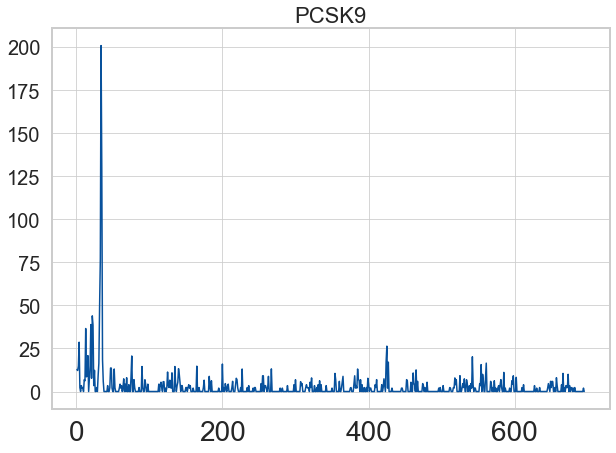

In [19]:
#sns.set_context('talk', font_scale=3)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(collpase_gene_coverage_to_codon(mu15_10min_avg), color='#08519c', linewidth=1.5)
ax.set_title('PCSK9')
#ax.set_ylabel('Normalized RPF count')
#fig.tight_layout()
fig.savefig("plots_savgol/savgol_pcsk9_10min_Avg_profile.pdf", dpi="figure", bbox_inches="tight")

In [14]:

PAPER_PRESET = {"style": "ticks", "font": "Arial", "context": "paper", 
                "rc": {"font.size":20, "axes.titlesize":22,
                       "axes.labelsize":28, 'axes.linewidth': 2,
                       "legend.fontsize":20, "xtick.labelsize": 28,
                       "ytick.labelsize":20, "xtick.major.size": 8.0,
                       "ytick.major.size": 8.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 20
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
from scipy import signal
from scipy import stats
import statsmodels.api as sm                                          
sns.set_style('whitegrid')


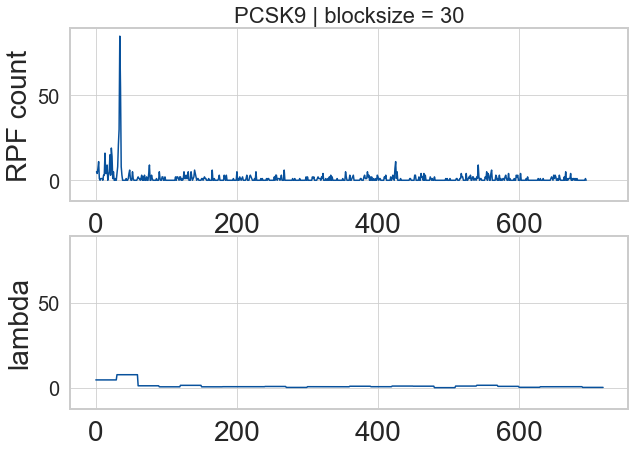

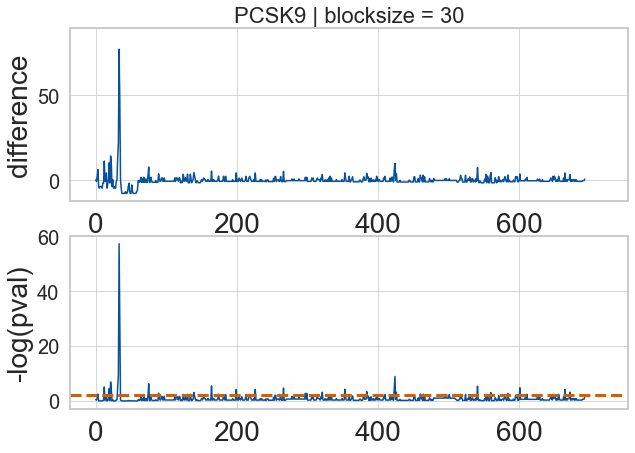

In [24]:
fig  = plt.figure(figsize=(10, 7))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(211)
ax1.plot(data,color='#08519c', linewidth=1.5)
ax1.set_title('PCSK9 | blocksize = 30')
ax1.set_ylabel('RPF count')

lambdas = get_blockwise_poisson_lambdas(data, blocksize=30)
pvalues = mark_extreme_points_poisson(data, lambdas, blocksize=30)

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
ax2.plot(expand_poisson_lambda(lambdas, blocksize=30),color='#08519c', linewidth=1.5)

ax2.set_ylabel('lambda')

fig.savefig('plots_savgol/pcsk9_10min_sum_gene_profile_poisson_blocksize30_top.pdf', dpi="figure", bbox_inches="tight")

fig  = plt.figure(figsize=(10, 7))

ax3 = plt.subplot(211, sharex=ax1, sharey=ax1)
ax3.set_title('PCSK9 | blocksize = 30')
ax3.plot(get_poisson_difference(data, lambdas, 30),color='#08519c', linewidth=1.5)
ax3.set_ylabel('difference')


ax4 = plt.subplot(212, sharex=ax1)
ax4.plot(-np.log10(pvalues),color='#08519c', linewidth= 1.5)
ax4.axhline(y=2, color="#D55E00", linestyle='dashed', linewidth=3)
ax4.set_ylabel('-log(pval)')
#ax4.set_title('Poission mean | blocksize = 9')

#fig.tight_layout()
fig.savefig('plots_savgol/pcsk9_10min_sum_gene_profile_poisson_blocksize30_bottom.pdf', dpi="figure", bbox_inches="tight")

/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


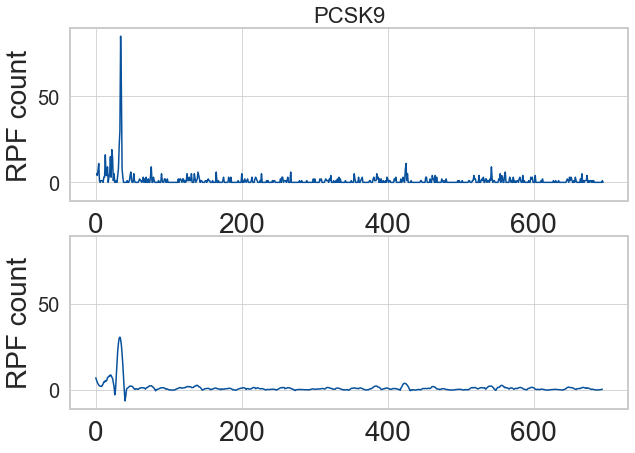

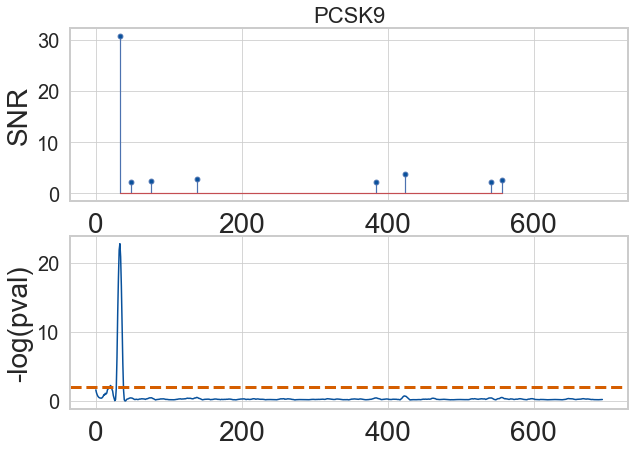

In [22]:
fig  = plt.figure(figsize=(10, 7))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(211)
ax1.plot(data,color='#08519c', linewidth=1.5)
ax1.set_title('PCSK9')
ax1.set_ylabel('RPF count')

filtered = savgol_filter(data, 15, 3)
ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
ax2.plot(filtered,color='#08519c', linewidth=1.5)
ax2.set_ylabel('RPF count')

fig.savefig('plots_savgol/pcsk9_10min_sum_gene_profile_zscore_golay_top.pdf', dpi="figure", bbox_inches="tight")

fig  = plt.figure(figsize=(10, 7))

ax3 = plt.subplot(211, sharex=ax1)
peaks_x, peaks_height = calculate_peaks(filtered, order=9, snr=3)
ax3.set_title('PCSK9')

ax3.set_ylabel('SNR')
markerline, stemlines, baseline = ax3.stem(peaks_x, peaks_height)#, linewidth=1.5)
markerline.set_markerfacecolor('#08519c')


ax4 = plt.subplot(212, sharex=ax1)
pvalues = -np.log10(gaussian_pvalue(filtered))
ax4.plot(pvalues,color='#08519c', linewidth=1.5)
ax4.set_ylabel('-log(pval)')
ax4.axhline(y=2, color="#D55E00", linestyle='dashed', linewidth=3)
fig.savefig('plots_savgol//pcsk9_10min_sum_gene_profile_zscore_golay_bottom.pdf', dpi="figure", bbox_inches="tight")

In [ ]:
significant_peaks_lambdawise = []
blocksizes = []
for i in range(3, 151, 3):
    lambdas = get_blockwise_poisson_lambdas(data, blocksize=i)
    pvalues = mark_extreme_points_poisson(data, lambdas, blocksize=i)
    pvalues = -np.log10(pvalues)
    filtered_pvals = list(filter(lambda x: x>=2, pvalues))
    blocksizes.append(i)
    significant_peaks_lambdawise.append(len(filtered_pvals))
fig, ax  = plt.subplots(figsize=(5, 5))
ax.plot(blocksizes,  significant_peaks_lambdawise, marker='o',color='#08519c', linewidth=1.5)
ax.set_ylabel('# Significant Peaks')
ax.set_xlabel('Blocksize')
fig.tight_layout()
fig.savefig('plots_savgol//pcsk9_blocksizes_vs_peaks_poisson.pdf', dpi="figure", bbox_inches="tight")

In [ ]:
ribotricer_output = read_ribotrcer_samples('/staging/as/skchoudh/re-ribo-analysis/hg38/SRP098789/ribotricer_results/')

In [ ]:
ribotricer_output.keys()

In [ ]:
mu15_10min_samples = samples_srx['1.5mu']['10min_1']
mu15_10min_samples 


In [ ]:
df = ribotricer_output['SRX2536426']

In [ ]:
df_subset = df.query("gene_id == 'ENSG00000169174' & ORF_type=='annotated'")

In [ ]:
df_subset

# Poisson blocksize

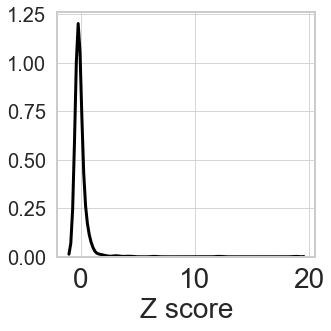

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

sns.kdeplot(Z_score(collpase_gene_coverage_to_codon(mu15_10min_sum)), color='black',  bw=.25, ax=ax, linewidth=3)
ax.set_label('Density')
ax.set_xlabel('Z score')
fig.tight_layout()
fig.savefig('plots_savgol//pcsk9_10min_sum_gene_profile_zscore.pdf', dpi="figure", bbox_inches="tight")

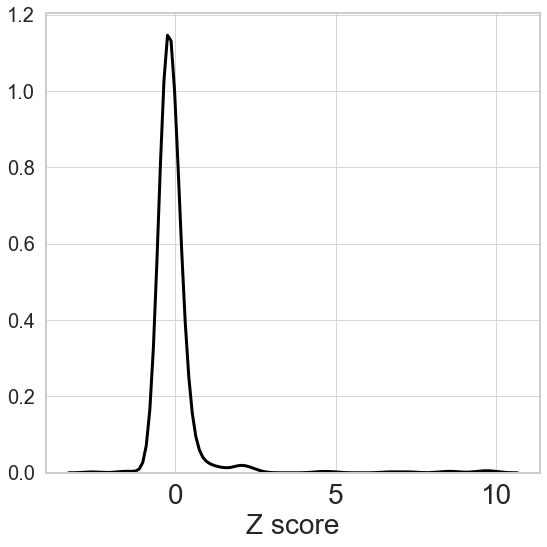

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

sns.kdeplot(Z_score(savgol_filter(data, 15, 3)), color='black',  bw=.25, ax=ax, linewidth=3)
ax.set_label('Density')
ax.set_xlabel('Z score')
fig.tight_layout()
fig.savefig('plots_savgol/pcsk9_10min_sum_gene_profile_zscore_savgol.pdf', dpi="figure", bbox_inches="tight")